# 第8部　正規線形モデル

## 3章　分散分析

### 実装：分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats
# 表示桁数の設定
pd.set_option('display.precision', 3)
np.set_printoptions(precision=3)

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
# 表示設定(書籍本文のレイアウトと合わせるためであり、必須ではありません)
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 60)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### 実装：データの作成と可視化

In [3]:
# サンプルデータの作成
weather = [
    'cloudy','cloudy',
    'rainy','rainy',
    'sunny','sunny'
]
beer = [6,8,2,4,10,12]

# データフレームにまとめる
weather_beer = pd.DataFrame({
    'beer'   : beer,
    'weather': weather
})
print(weather_beer)

   beer weather
0     6  cloudy
1     8  cloudy
2     2   rainy
3     4   rainy
4    10   sunny
5    12   sunny


<AxesSubplot:xlabel='weather', ylabel='beer'>

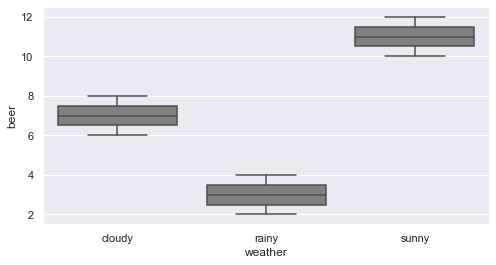

In [4]:
# 箱髭図を描く
sns.boxplot(x='weather',y='beer',
            data=weather_beer, color='gray')

### 実装：総平均と水準別平均の計算

In [5]:
# ビールの売り上げデータを扱いやすくするため切り出す
y = weather_beer.beer.to_numpy()
y

array([ 6,  8,  2,  4, 10, 12], dtype=int64)

In [6]:
# データの総平均
y_bar = np.mean(y)
y_bar

7.0

In [7]:
# 各データの平均値
y_bar_j = weather_beer.groupby('weather').mean()
print(y_bar_j)

         beer
weather      
cloudy    7.0
rainy     3.0
sunny    11.0


### 実装：分散分析①群間・群内平方和の計算

In [8]:
# 水準ごとのサンプルサイズ
n_j = 2
# 天気による影響だけを考えた場合の売り上げ
effect = np.repeat(y_bar_j.beer, n_j)
effect

weather
cloudy     7.0
cloudy     7.0
rainy      3.0
rainy      3.0
sunny     11.0
sunny     11.0
Name: beer, dtype: float64

In [9]:
# 群間の平方和
ss_b = np.sum((effect - y_bar) ** 2 )
ss_b

64.0

In [10]:
# 天気では説明することができない誤差
resid = y - effect
resid

weather
cloudy   -1.0
cloudy    1.0
rainy    -1.0
rainy     1.0
sunny    -1.0
sunny     1.0
Name: beer, dtype: float64

In [11]:
# 群内の平方和
ss_w = np.sum(resid ** 2)
ss_w

6.0

### 実装：分散分析②群間・群内分散の計算

In [12]:
df_b = 2 # 群間変動の自由度
df_w = 3 # 群内変動の自由度

In [13]:
# 群間の平均平方(分散)
sigma_b = ss_b / df_b
sigma_b

32.0

In [14]:
# 群内の平均平方(分散)
sigma_w = ss_w / df_w
sigma_w

2.0

### 実装：分散分析③p値の計算

In [15]:
# F比
f_ratio = sigma_b / sigma_w
f_ratio

16.0

In [16]:
# p値
p_value = 1 - stats.f.cdf(x=f_ratio, dfn=df_b, dfd=df_w)
round(p_value, 3)

0.025

### 実装：statsmodelsによる分散分析

In [17]:
# 正規線形モデルの構築
anova_model = smf.ols(formula='beer ~ weather',
                      data = weather_beer).fit()

In [18]:
# 分散分析の結果
print(sm.stats.anova_lm(anova_model, typ=2))

          sum_sq   df     F  PR(>F)
weather     64.0  2.0  16.0   0.025
Residual     6.0  3.0   NaN     NaN


In [19]:
# 総平方和
np.sum((y - y_bar)**2)

70.0

### モデルの係数の解釈

In [20]:
anova_model.params

Intercept           7.0
weather[T.rainy]   -4.0
weather[T.sunny]    4.0
dtype: float64

### 実装：モデルを用いて誤差と効果を分離する

In [21]:
#当てはめ値
fitted = anova_model.fittedvalues
fitted

0     7.0
1     7.0
2     3.0
3     3.0
4    11.0
5    11.0
dtype: float64

In [22]:
# 残差
anova_model.resid

0   -1.0
1    1.0
2   -1.0
3    1.0
4   -1.0
5    1.0
dtype: float64

### 実装：回帰モデルにおける分散分析

#### モデルの推定

In [23]:
# データの読み込み
beer = pd.read_csv('8-1-1-beer.csv')

# モデルの推定
lm_model = smf.ols(formula='beer ~ temperature', 
                   data = beer).fit()

#### F比の計算

In [24]:
print('モデルの自由度：', lm_model.df_model)
print('残差の自由度　：', lm_model.df_resid)

モデルの自由度： 1.0
残差の自由度　： 28.0


In [25]:
# 応答変数
y = beer.beer
# 当てはめ値
effect = lm_model.fittedvalues
# 残差
resid = lm_model.resid
# 気温の持つ効果の大きさ
y_bar = np.mean(y)
ss_model = np.sum((effect - y_bar) ** 2)
sigma_model = ss_model / lm_model.df_model
# 残差の大きさ
ss_resid = np.sum((resid) ** 2)
sigma_resid = ss_resid /  lm_model.df_resid
# F比
f_value_lm = sigma_model / sigma_resid
round(f_value_lm, 3)

28.447

In [26]:
# 参考：p値は桁落ちでほぼ0になる(書籍には載っていないコードです)
1 - stats.f.cdf(x=f_value_lm, dfn=lm_model.df_model, dfd=lm_model.df_resid)

1.1148907825053733e-05

#### 分散分析の実行

In [27]:
# 分散分析表
print(sm.stats.anova_lm(lm_model, typ=2))

               sum_sq    df       F     PR(>F)
temperature  1651.532   1.0  28.447  1.115e-05
Residual     1625.582  28.0     NaN        NaN


In [28]:
# モデルのsumamry
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beer   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     28.45
Date:                Sun, 22 May 2022   Prob (F-statistic):           1.11e-05
Time:                        15:43:38   Log-Likelihood:                -102.45
No. Observations:                  30   AIC:                             208.9
Df Residuals:                      28   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.6102      3.235     10.699      0.000      27.984      41.237
temperature     0.7654      0.144      5.334      0.000       0.471       1.059
==============================================================================
Omnibus:                        0.587   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.290
Skew:                          -0.240   Prob(JB):                        0.865
Kurtosis:                       2.951   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 平方和の分解

In [29]:
print('総平方和 　：', round(np.sum((y - y_bar)**2), 3))
print('SS_B + SS_W：', round(ss_model + ss_resid, 3))

総平方和 　： 3277.115
SS_B + SS_W： 3277.115


In [30]:
# ss_modelの異なる求め方
round(np.sum((y - y_bar)**2) - np.sum((resid) ** 2), 3)

1651.532